# Cercis flower analysis

This notebook assumes we have already processed the flower images with `pypl analyze`. Firist load the dataframe from CSV.

In [23]:
import pandas as pd

df = pd.read_csv('../output_cercis/cercis.colors.csv')

# clean up image names
df['Image'] = df.apply(lambda r: str(r['Image']).replace('data_cercis/', '').replace('.jpg', ''), axis=1)

# drop rows with unknowns (malformed filename format)
df.dropna(how='any', inplace=True)

# convert hue to [1, 360] scale and create 72 equally spaced bins (represented by their centers)
hsv_divisor = 5
hsv_ranges = [((k * hsv_divisor) + hsv_divisor) for k in range(0, int(360 / hsv_divisor))]
df['HH'] = df.apply(lambda row: int(float(row['H']) * 360), axis=1)
df['HueBin'] = df.apply(lambda row: int(row['HH']) - (int(row['HH']) % hsv_divisor), axis=1)

# subset HSV and RGB frames
hsv_subset = df[['H', 'S', 'V', 'HH', 'HueBin']].astype(float)
rgb_subset = df[['R', 'G', 'B']].astype(float)
df

,Image,Hex,R,G,B,H,S,V,Freq,Dens,HH,HueBin
0,1-1 (1),#faf9f9,0.980392,0.976471,0.976471,0.000000,0.004000,0.980392,8970,0.007992,0,0
1,1-1 (1),#f5fdf8,0.960784,0.992157,0.972549,0.395833,0.031621,0.992157,2295,0.002045,142,140
2,1-1 (1),#1f020b,0.121569,0.007843,0.043137,0.948276,0.935484,0.121569,121756,0.108476,341,340
3,1-1 (1),#5b2a55,0.356863,0.164706,0.333333,0.853741,0.538462,0.356863,114609,0.102108,307,305
4,1-1 (1),#fbfefd,0.984314,0.996078,0.992157,0.444444,0.011811,0.996078,17655,0.015729,160,160
...,...,...,...,...,...,...,...,...,...,...,...,...
4007,4-99,#450a22,0.270588,0.039216,0.133333,0.932203,0.855072,0.270588,347031,0.096796,335,335
4008,4-99,#ba53a7,0.729412,0.325490,0.654902,0.864078,0.553763,0.729412,255012,0.071129,311,310
4009,4-99,#a2378c,0.635294,0.215686,0.549020,0.867601,0.660494,0.635294,617202,0.172154,312,310
4010,4-99,#cc86bc,0.800000,0.525490,0.737255,0.871429,0.343137,0.800000,89985,0.025099,313,310


Next we can cluster colors in RGB space and bin them according to hue.

In [24]:
from collections import Counter, OrderedDict
from scipy.cluster.vq import kmeans2

rgb_centers, rgb_labels = kmeans2(rgb_subset, 15)
rgb_counts = dict(Counter(rgb_labels))
rgb_counts = {(abs(int(float(c[0]) * 256)), abs(int(float(c[1]) * 256)), abs(int(float(c[2]) * 256))): rgb_counts[l] for c, l in zip(rgb_centers, rgb_labels)}
rgb_total = sum(rgb_counts.values())
rgb_props = {k: (v / rgb_total) for k, v in rgb_counts.items()}

hsv_counts = Counter(hsv_subset['HueBin'])
for key in [k for k in hsv_ranges if k not in list(hsv_counts.keys())]: hsv_counts[key] = 0  # pad zeroes
hsv_total = sum(hsv_counts.values())
hsv_props = OrderedDict(sorted({k: float(v / hsv_total) for k, v in hsv_counts.items() if v != 0}.items()))

/Users/wes/dev/pytcherplants/venv/lib/python3.7/site-packages/scipy/cluster/vq.py:607: UserWarning:

One of the clusters is empty. Re-run kmeans with a different initialization.



Now view some plots, starting with hex codes.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


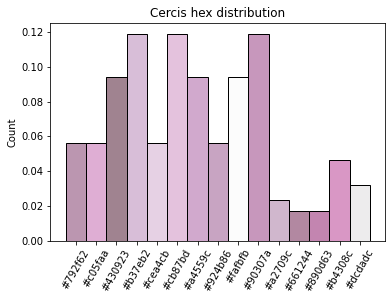

In [17]:
import matplotlib.pyplot as plt

from pytcherplants.plotting import *

plot_hex_distribution(rgb_props, f"Cercis hex distribution")
plt.xticks(rotation=60)
plt.legend().remove()
plt.show()

Next view RGB clusters.

In [18]:
fig = plot_rgb_distribution(rgb_props, "Cercis RGB distribution")
camera = dict(eye=dict(x=2.5, y=0, z=0))  # rotate to x axis
fig.update_layout(scene_camera=camera, title='eye = (x:2.5., y:0, z:0.)')
fig.show()
# fig.write_image(join(output_directory, title + '.rgb.x.png'))
camera = dict(eye=dict(x=0, y=2.5, z=0))  # rotate to y axis
fig.update_layout(scene_camera=camera, title='eye = (x:0., y:2.5, z:0.)')
fig.show()
# fig.write_image(join(output_directory, title + '.rgb.y.png'))
camera = dict(eye=dict(x=0, y=0, z=2.5))  # rotate to z axis
fig.update_layout(scene_camera=camera, title='eye = (x:0., y:0, z:2.5.)')
fig.show()

Next view hue distribution.

In [25]:
from plotly import graph_objects as go, express as px

from pytcherplants.utils import *

cmap = {str(k): f"hsv({str(int(k / 360 * 100))}%, 50%, 50%)" for k in hsv_props.keys()}
ff = pd.DataFrame(zip([str(k) for k in hsv_props.keys()], hsv_props.values()), columns=['bin', 'mass'])
fig = px.bar_polar(
    ff,
    title="Cercis hue distribution",
    r='mass',
    range_r=[0, max(ff['mass'])],
    theta='bin',
    range_theta=[0, 360],
    color='bin',
    color_discrete_map=cmap,
    labels=None)
#fig.update_layout(showlegend=False, polar_angularaxis_tickfont_size=7, polar_radialaxis_tickfont_size=7)
#fig = plot_hue_distribution(hsv_props, f"Cercis hue distribution")
fig.show()

{'0.0': 'hsv(0%, 50%, 50%)', '15.0': 'hsv(4%, 50%, 50%)', '25.0': 'hsv(6%, 50%, 50%)', '35.0': 'hsv(9%, 50%, 50%)', '40.0': 'hsv(11%, 50%, 50%)', '45.0': 'hsv(12%, 50%, 50%)', '55.0': 'hsv(15%, 50%, 50%)', '70.0': 'hsv(19%, 50%, 50%)', '75.0': 'hsv(20%, 50%, 50%)', '80.0': 'hsv(22%, 50%, 50%)', '85.0': 'hsv(23%, 50%, 50%)', '90.0': 'hsv(25%, 50%, 50%)', '95.0': 'hsv(26%, 50%, 50%)', '100.0': 'hsv(27%, 50%, 50%)', '105.0': 'hsv(29%, 50%, 50%)', '120.0': 'hsv(33%, 50%, 50%)', '125.0': 'hsv(34%, 50%, 50%)', '140.0': 'hsv(38%, 50%, 50%)', '145.0': 'hsv(40%, 50%, 50%)', '150.0': 'hsv(41%, 50%, 50%)', '155.0': 'hsv(43%, 50%, 50%)', '160.0': 'hsv(44%, 50%, 50%)', '165.0': 'hsv(45%, 50%, 50%)', '170.0': 'hsv(47%, 50%, 50%)', '180.0': 'hsv(50%, 50%, 50%)', '210.0': 'hsv(58%, 50%, 50%)', '240.0': 'hsv(66%, 50%, 50%)', '250.0': 'hsv(69%, 50%, 50%)', '255.0': 'hsv(70%, 50%, 50%)', '260.0': 'hsv(72%, 50%, 50%)', '265.0': 'hsv(73%, 50%, 50%)', '270.0': 'hsv(75%, 50%, 50%)', '275.0': 'hsv(76%, 50%, 5